In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
# numerical python
import matplotlib.pyplot as plt

import os
import itertools
from IPython.display import SVG
import math
import plotly.graph_objects as go

import networkx as nx
from networkx.linalg.graphmatrix import adjacency_matrix
from networkx.convert_matrix import to_numpy_matrix as to_np_mx


from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering, AffinityPropagation
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist

In [ ]:
def get_child_list(df, parent_id): #Get list of children of a specific list of nodes
    list_of_children = []
    list_of_children.append(df[df['container'] == parent_id]['elemid'].values)

    for i_, r_ in df[df['container'] == parent_id].iterrows():
        if r_['elemid'] != parent_id:
            list_of_children.append(get_child_list(df, r_['elemid'])) #Recursion
    list_of_children =  [item for sublist in list_of_children for item in sublist]
    return list_of_children

In [ ]:
def get_graph_dic(k, container_col = 'container', elem_col='elemid'):  #Make a dict of container:element
    x = k.groupby([container_col])[elem_col].apply(lambda k: list(k)).to_frame().reset_index()
    dic = dict(zip(x[container_col],x[elem_col])) #Make a dict of container:element
    return dic

def BFS(dic,building_id): #Perform BFS to get the children of every parent (the elements in building_id)
    g = nx.Graph(dic) #Make a graph object from NetworkX library
    new_df = pd.DataFrame(columns=['parent_id', 'children'])
    for i in building_id:
        try:
            temp_df = pd.DataFrame(columns=['parent_id', 'children'])
            temp_df['children'] = pd.Series(list(nx.descendants(g, i))) # Use graph object to find all children
            temp_df['parent_id'] = i
            new_df = new_df.append(temp_df).drop_duplicates() #Add on children to a new_df
        except:
            display(i)
    return new_df

def get_children_parents(k,building_id, excluded_id=[], container_col = 'container', elem_col='elemid'): #Put the 2 functions above into the final function
    """
    k: father dataframe
    Get all children of each of building_id
    """
    dic = get_graph_dic(k,container_col,elem_col)
    new_df = BFS(dic,building_id)
    return new_df

In [ ]:
def preprocess(path): #This function will do all of the preprocessing; however, in the first example, all steps are showed for better understanding
  """
  path: path to the element table csv file
  """
  k = pd.read_csv(path)
  k = k[k.columns[:4]]
  k.columns = ['elemid','elemtype','container','centroid']
  k = k.dropna(subset=['container'])

  excluded_list = ['IFCBUILDINGSTOREY','VIRTUALBUILDINGSTOREY','IFCGROUP','IFCBUILDING','IFCPROJECT','IFCSITE',
                  'IFCSYSTEM','VIRTUALIFCSITE','VIRTUALBUILDING','IFCVIRTUALELEMENT','VIRTUALIFCPROJECT']
  excluded_id = k[k['elemtype'].isin(excluded_list)]['elemid'].unique()
  building_id = list(k[k['elemtype']=='IFCBUILDING']['elemid'].unique())

  new_df = get_children_parents(k,building_id)
  parent_encode = dict(zip(building_id,np.arange(len(building_id))))

  df = new_df.set_index('children').join(k.set_index('elemid')).drop('container',axis=1)
  df['parent'] = df['parent_id'].map(parent_encode)
  df.index.name= 'id'
  df.reset_index(inplace=True)

  # Remove nan values in centroid columns
  df = df[~(df['centroid'].isna())]
  # Get coordinates x,y and z from the centroid column
  df['centroid_coordinates'] = df['centroid'].str.replace("(","").str.replace(")","").str.split(",")
  df['x'],df['y'],df['z'] = df['centroid_coordinates'].str[0],df['centroid_coordinates'].str[1],df['centroid_coordinates'].str[2]
  # Remove centroid column
  df.drop(['centroid','centroid_coordinates'],axis=1,inplace=True)
  # Change data type of x,y,z to be float
  df = df.astype({'x':float,'y':float,'z':float})
  df = df.sort_values(by='id')
  df['idx'] = df.index

  #Perform min-max scaler
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  scaler.fit(df[['x','y','z']])
  df.loc[:,['x','y','z']] = scaler.transform(df[['x','y','z']])
  return df

# SPATIAL CLUSTERING


## MODEL 001- CONDO

In [ ]:
#Read data
k = pd.read_csv('/content/drive/MyDrive/internship/elem_001.csv')
k = k.dropna(subset=['container']) #Drop elements not having containers

FileNotFoundError: ignored

In [ ]:
excluded_list = ['VIRTUALBUILDINGSTOREY','IFCGROUP','IFCBUILDING','IFCPROJECT','IFCSITE',
                'VIRTUALIFCSITE','VIRTUALBUILDING','VIRTUALIFCPROJECT'] # Exclude virtual objects and items at higher hiarerchy than ifc building
excluded_id = k[k['elemtype'].isin(excluded_list)]['elemid'].unique()
building_id = list(k[k['elemtype']=='IFCBUILDING']['elemid'].unique()) # Get elemid of items having IFCbuilding tag

In [ ]:
new_df = get_children_parents(k,building_id) # Initial clustering, use DFS to find children of all "building_id"

In [ ]:
# Add parents column to the original DF
parent_encode = dict(zip(building_id,np.arange(len(building_id))))

df = new_df.set_index('children').join(k.set_index('elemid'))
df['parent'] = df['parent_id'].map(parent_encode)
df.index.name= 'id'
df.reset_index(inplace=True)

Preprocessing

In [ ]:
# Remove nan values in centroid columns
df = df[~(df['centroid'].isna())]
# Get coordinates x,y and z from the centroid column
df['centroid_coordinates'] = df['centroid'].str.replace("(","").str.replace(")","").str.split(",")
df['x'],df['y'],df['z'] = df['centroid_coordinates'].str[0],df['centroid_coordinates'].str[1],df['centroid_coordinates'].str[2]
# Remove centroid column
df.drop(['centroid','centroid_coordinates'],axis=1,inplace=True)
# Change data type of x,y,z to be float
df = df.astype({'x':float,'y':float,'z':float})
df = df.sort_values(by='id')
df['idx'] = df.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [ ]:
#Min-max scaler
scaler = MinMaxScaler()
scaler.fit(df[['x','y','z']])
df.loc[:,['x','y','z']] = scaler.transform(df[['x','y','z']])

In [ ]:
# First visualize the BIM 
import plotly.graph_objects as go

PLOT = go.Figure()

PLOT.add_trace(go.Scatter3d(x = df['x'],
                                y = df['y'],
                                z = df['z'],
                                mode = 'markers', marker_size = 3, marker_line_width = 1))

PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'x', titlefont_color = 'black'),
                                yaxis=dict(title = 'y', titlefont_color = 'black'),
                                zaxis=dict(title = 'z', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
# After Initial clustering

PLOT = go.Figure()

for C in list(df.parent.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = df[df.parent == C]['x'],
                                y = df[df.parent == C]['y'],
                                z = df[df.parent == C]['z'],
                                mode = 'markers', marker_size = 3, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))
PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'x', titlefont_color = 'black'),
                                yaxis=dict(title = 'y', titlefont_color = 'black'),
                                zaxis=dict(title = 'z', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

Perform DBScan, Kmeans and evaluation in a loop and pick the eps value that gives the highest Silhouette score

In [ ]:
s_score = []
eps_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5] # List of different eps values to try
for eps in eps_list:
  x = df.groupby(['parent']).agg({
      'x':'mean',
      'y':'mean',
      'z':'mean'
  })

  db_default = DBSCAN(eps = eps,min_samples=0).fit(x) #Perform DBScan to concatenate centroids of initial clusters
  labels = db_default.labels_
  parent_dic = dict(zip(list(x.index),labels.astype(str))) #Update new parents labels after DBScan

  df1 = df.copy() #df1 is a dummy dataframe copy of df. It is used only within this loop
  df1['parent'] = df1['parent'].replace(parent_dic) #Update new parents labels after DBScan

  #Perform one-hot encoding on the parents column (col)
  onehot = OneHotEncoder() 
  onehot_parent = onehot.fit_transform((df1['parent'].values).reshape(-1,1)).toarray()
  df1.loc[:,df1['parent'].unique()] = onehot_parent
  cols_names = ['x','y','z']+list(df1['parent'].unique())

  # Perform Kmeans clustering
  km = KMeans(n_clusters=df1['parent'].nunique())
  km = km.fit(df1[cols_names].values)
  prediction = km.predict(df1[cols_names].values) #Output building tags

  df1.loc[:,'clusters'] = prediction
  try:
    s_score.append(silhouette_score(df1[cols_names],prediction,sample_size=20000)) #append silhouette score to the list of score to compare
  except:
    s_score.append(-1) #In case eps too large, all centroids are concatenated, we exclude this case by setting score = -1

silhouette_score
0.05          0.788614
0.10          0.788272
0.15          0.788356
0.20          0.788311
0.25          0.791295
0.30          0.790798
0.35          0.791330
0.40          0.791344
0.45          0.790885
0.50          0.745456

(0.775, 0.81)

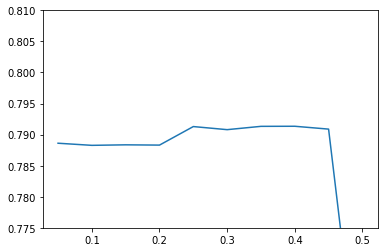

In [ ]:
eps_list = pd.DataFrame(s_score,eps_list,columns=['silhouette_score'])
best_eps = eps_list[eps_list['silhouette_score'] == eps_list['silhouette_score'].max()].index.values[0]
display(eps_list)
#Make a brief plot of eps vs silhouette score
plt.plot(eps_list.index,eps_list['silhouette_score'])
plt.ylim([0.775,0.81])

With the best eps, we perform the process inside the loop again. This is surely not the optimal way to write the code, but the running time is low and computing cost for this loop is cheap, then it is ok.

In [ ]:
#Perform DBScan
db_default = DBSCAN(eps = best_eps,min_samples=0).fit(x)
labels = db_default.labels_
parent_dic = dict(zip(list(x.index),labels.astype(str)))

df1 = df.copy()
df1['parent'] = df1['parent'].replace(parent_dic)

onehot = OneHotEncoder()
onehot_parent = onehot.fit_transform((df1['parent'].values).reshape(-1,1)).toarray()
df1.loc[:,df1['parent'].unique()] = onehot_parent
#Show how many buildings clustered
display(df1['parent'].nunique())
#Perform Kmeans clustering 
km = KMeans(n_clusters=df1['parent'].nunique())
km = km.fit(df1[cols_names].values)
prediction = km.predict(df1[cols_names].values)

df1.loc[:,'clusters'] = prediction

3

In [ ]:
#Get the coordinates of the centroids of the clusters for visualization
x_centroid = [k[0] for k in km.cluster_centers_]
y_centroid = [k[1] for k in km.cluster_centers_]
z_centroid = [k[2] for k in km.cluster_centers_]

In [ ]:
# Plot the result
PLOT = go.Figure()

for C in list(df1.clusters.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = df1[df1.clusters == C]['x'],
                                y = df1[df1.clusters == C]['y'],
                                z = df1[df1.clusters == C]['z'],
                                mode = 'markers', marker_size = 2, marker_line_width = 1,
                                name = 'Building ' + str(C)))
    
PLOT.add_trace(go.Scatter3d(    x = x_centroid,
                                y = y_centroid,
                                z = z_centroid,
                                mode = 'markers',marker=dict(
                                                            color='rgb(255,247,0)',
                                                            size=10,
                                                            line=dict(
                                                                color='MediumPurple',
                                                                width=2)
                                                            ), name = 'Centroid'
                                ))

PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'x', titlefont_color = 'black'),
                                yaxis=dict(title = 'y', titlefont_color = 'black'),
                                zaxis=dict(title = 'z', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
#Calculate the evalutaion score (again)
silhouette_score(df1[cols_names],prediction,sample_size=20000) #Get the score by using a small sample size, since using everything to calculate score will takes a long time

0.7315554060264429

## MODEL 002- OOG

In [ ]:
df = preprocess('/content/drive/MyDrive/internship/elem_002') #The preprocess function will do the job of preprocessing

In [ ]:
df_vis = df.sample(50000,random_state=1234) # get the sample of 50000 for visualizing. The whole model is too big for the notebook to handle its plot

In [ ]:
# First visualize the BIM 
import plotly.graph_objects as go

PLOT = go.Figure()

PLOT.add_trace(go.Scatter3d(x = df_vis['x'],
                                y = df_vis['y'],
                                z = df_vis['z'],
                                mode = 'markers', marker_size = 3, marker_line_width = 1))
PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'x', titlefont_color = 'black'),
                                yaxis=dict(title = 'y', titlefont_color = 'black'),
                                zaxis=dict(title = 'z', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
#After clustering
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(df_vis.parent.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = df_vis[df_vis.parent == C]['x'],
                                y = df_vis[df_vis.parent == C]['y'],
                                z = df_vis[df_vis.parent == C]['z'],
                                mode = 'markers', marker_size = 2, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))
PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'x', titlefont_color = 'black'),
                                yaxis=dict(title = 'y', titlefont_color = 'black'),
                                zaxis=dict(title = 'z', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [ ]:
now1=datetime.now()

s_score = []
eps_list = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
for eps in eps_list:
  x = df.groupby(['parent']).agg({
      'x':'mean',
      'y':'mean',
      'z':'mean'
  })
  # fig = plt.figure() #Optional plotting the centroids for better on-the-run evaluation
  # ax = fig.add_subplot(projection='3d')
  # for i in x.index:
  #   ax.scatter(x.loc[i,'x'], x.loc[i,'y'], x.loc[i,'z'])

  db_default = DBSCAN(eps = eps,min_samples=0).fit(x)
  labels = db_default.labels_
  parent_dic = dict(zip(list(x.index),labels.astype(str)))

  df1 = df.copy()
  df1['parent'] = df1['parent'].replace(parent_dic)

  onehot = OneHotEncoder()
  onehot_parent = onehot.fit_transform((df1['parent'].values).reshape(-1,1)).toarray()
  df1.loc[:,df1['parent'].unique()] = onehot_parent
  cols_names = ['x','y','z']+list(df1['parent'].unique())

  km = KMeans(n_clusters=df1['parent'].nunique())
  km = km.fit(df1[cols_names].values)
  prediction = km.predict(df1[cols_names].values)

  df1.loc[:,'clusters'] = prediction
  try:
    s_score.append(silhouette_score(df1[cols_names],prediction,sample_size=20000))
  except:
    s_score.append(-1)
  del df1

now2=datetime.now()
display((now2-now1).total_seconds()) #Show the total running time

NameError: ignored

In [ ]:
eps_list = pd.DataFrame(s_score,eps_list,columns=['silhouette_score'])
display(eps_list)
best_eps = eps_list[eps_list['silhouette_score'] == eps_list['silhouette_score'].max()].index.values[0]
plt.plot(eps_list.index,eps_list['silhouette_score'])
plt.ylim([0.775,0.81])

silhouette_score
0.01              NaN
0.05              NaN
0.10              NaN
0.15              NaN
0.20              NaN
0.25              NaN
0.30              NaN
0.35              NaN
0.40              NaN
0.45              NaN
0.50              NaN

IndexError: ignored

In [ ]:
db_default = DBSCAN(eps = best_eps,min_samples=0).fit(x)
labels = db_default.labels_
parent_dic = dict(zip(list(x.index),labels.astype(str)))

df1 = df.copy()
df1['parent'] = df1['parent'].replace(parent_dic)

onehot = OneHotEncoder()
onehot_parent = onehot.fit_transform((df1['parent'].values).reshape(-1,1)).toarray()
df1.loc[:,df1['parent'].unique()] = onehot_parent
cols_names = ['x','y','z']+list(df1['parent'].unique())


km = KMeans(n_clusters=df1['parent'].nunique())
km = km.fit(df1[cols_names].values)
prediction = km.predict(df1[cols_names].values)

df1.loc[:,'clusters'] = prediction

NameError: ignored

In [ ]:
#Final Result
df1_vis = df1.sample(10000) #Again, sampling for visualization

x_centroid = [k[0] for k in km.cluster_centers_]
y_centroid = [k[1] for k in km.cluster_centers_]
z_centroid = [k[2] for k in km.cluster_centers_]
PLOT = go.Figure()


for C in list(df1_vis.clusters.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = df1_vis[df1_vis.clusters == C]['x'],
                                y = df1_vis[df1_vis.clusters == C]['y'],
                                z = df1_vis[df1_vis.clusters == C]['z'],
                                mode = 'markers', marker_size = 2, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))
    
PLOT.add_trace(go.Scatter3d(    x = x_centroid,
                                y = y_centroid,
                                z = z_centroid,
                                mode = 'markers',marker=dict(
                                                            color='rgb(255,247,0)',
                                                            size=10,
                                                            line=dict(
                                                                color='MediumPurple',
                                                                width=2)
                                                            )
                                ))

PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'x', titlefont_color = 'black'),
                                yaxis=dict(title = 'y', titlefont_color = 'black'),
                                zaxis=dict(title = 'z', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

NameError: ignored

# Graph Clustering

In [ ]:
def preprocess_cg(modelnum=5 ): #The function for the pre-processing circulation graph
  linkpath = '/content/drive/MyDrive/internship/graph_link_00' + str(modelnum) #Read link_table
  nodepath = '/content/drive/MyDrive/internship/graph_node_00' + str(modelnum) #Read node_table
  
  link_cg = pd.read_csv(linkpath,header=None)
  link_cg.columns = ['link_name','start_node_id','end_node_id','link_type']

  node_cg = pd.read_csv(nodepath,header=None)
  node_cg.columns = ['node_id','node_name','node_type','hierarchy_level','parent_node_id']

  
  link_cg.drop_duplicates(inplace=True) #Drop duplicates

  #Get the node names and their corresponding elemid from node table, then replace all node names in the link_table by elemid
  node_name = dict(zip(node_cg['node_id'],node_cg['node_name'])) #Get the dict node_id:node_name
  link_cg['start_node_id'] = link_cg['start_node_id'].replace(node_name)
  link_cg['end_node_id'] = link_cg['end_node_id'].replace(node_name)

  #Get the node type and their corresponding values from node table, then add 2 new columns of node type both for start and end nodes
  node_type = dict(zip(node_cg['node_name'],node_cg['node_type'])) #Get the dict node_name:type
  link_cg['start_type'] = link_cg['start_node_id'].replace(node_type)
  link_cg['end_type'] = link_cg['end_node_id'].replace(node_type)

  # link_cg = link_cg.dropna()
  link_cg['link_type'] = link_cg['start_type']+"-" + link_cg['end_type'] # Get the string indidcates a specific edge (optional)
  
  return link_cg, node_cg

In [ ]:
def preprocess_k(modelnum = 5): #Preprocess element table
  if modelnum !=1: #This comes from the fact that model 001 is saved in different format than others, but in future, one can change this to fit a more coherent csv structure
    kpath = '/content/drive/MyDrive/internship/elem_00' + str(modelnum) #Models are labeled with code 00x, for other naming convention, please change the kpath string
    k = pd.read_csv(kpath,header=None)
    k = k[k.columns[:4]]
    k.columns = ['elemid','elemtype','container','centroid']
  else:
    kpath = '/content/drive/MyDrive/internship/elem_00' + str(modelnum) + '.csv'
    k = pd.read_csv(kpath)
  
  #Get coordinates of the centroids of the elements' bounding boxes
  k['centroid_coordinates'] = k['centroid'].str.replace("(","").str.replace(")","").str.split(",")
  k['x'],k['y'],k['z'] = k['centroid_coordinates'].str[0],k['centroid_coordinates'].str[1],k['centroid_coordinates'].str[2]
  k[['x','y','z']] = k[['x','y','z']].astype(float)
  k = k[['elemid','container','x','y','z']] #Remove other unimportant columns for this approach
  # k.drop(['container'],axis=1,inplace=True)
  return k

In [ ]:
def plot_graph(link_cg, num='sample'): #Function for graph plotting
  if num=='sample': #Plot option of graphing only unique start nodes and their only 1 end node
    linkcg = link_cg[link_cg['end_node_id'].isin(link_cg.groupby(['start_node_id'])['end_node_id'].sample(1))]
  elif num == 'all': #Plot everything (not recommended due to the visualization overload)
    linkcg = link_cg
  else: #Plot just a number of randomized vertex+nodes
    linkcg = link_cg.sample(num)
  
  linkcg.reset_index(drop=True,inplace=True)
  PLOT = go.Figure()

  #Plot nodes
  PLOT.add_trace(go.Scatter3d(x = linkcg['sx'],
                                  y = linkcg['sy'],
                                  z = linkcg['sz'],
                                  mode = 'markers', marker_size = 3, marker_line_width = 1,name='start_nodes'))
  PLOT.add_trace(go.Scatter3d(x = linkcg['ex'],
                                  y = linkcg['ey'],
                                  z = linkcg['ez'],
                                  mode = 'markers', marker_size = 3, marker_line_width = 1,name='end_nodes'))
  #Plot edges of the nodes
  for i in range(len(linkcg)): 
      x = linkcg.loc[i:i,['sx','sy','sz']]
      g = linkcg.loc[i:i,['ex','ey','ez']].rename(columns=dict(zip(['ex','ey','ez'],['sx','sy','sz'])))
      x = pd.concat([x,g])
      PLOT.add_trace(go.Scatter3d(x=x['sx'],y=x['sy'],z=x['sz'],marker_size = 2,name='1', legendgroup='1', marker=dict(color='black')))
      del x,g
  PLOT.update_layout(width = 1000, height = 800, autosize = True, showlegend = True,
                    scene = dict(xaxis=dict(title = 'x', titlefont_color = 'black'),
                                  yaxis=dict(title = 'y', titlefont_color = 'black'),
                                  zaxis=dict(title = 'z', titlefont_color = 'black')),
                    font = dict(family = "Gilroy", color  = 'black', size = 12))
  PLOT.update_layout(autosize=False,
      width=800,
      height=800)
  PLOT.update(layout_showlegend=False)
  PLOT.show()

In [ ]:
def adjacent_matrix(link_cg, k, mode='cg'): #Get the Adjacent Matrix for spectral clustering
  if mode == 'all': #Get the adjacent matrix of whole BIM graph (not recommended since it is very big and can crash the computer)
    y = k[['elemid','container']].rename(columns={'container':'start_node_id','elemid':'end_node_id'}).reset_index(drop=True)
    x = link_cg[['start_node_id','end_node_id','weight']]
    x = pd.concat([x,y]).drop_duplicates()
  elif mode == 'cg': #Get the adjacent matrix of the circulation graph only
    x = link_cg[['start_node_id','end_node_id','weight']]
  G = nx.from_pandas_edgelist(x,'start_node_id','end_node_id',edge_attr=['weight']) #Make a graph object out of circulation graph
  
  Gcc = sorted(nx.connected_components(G), key=len, reverse=True) #Show all CCs in the Graph. It depends on the data scientist to decide which CC to keep, which to ignore -- This is to be further developed in the future
  #But at this point, only the largest CC (LCC) is used
  G0 = G.subgraph(Gcc[0]) # Get the largest cc (LCC)
  adj_mat = nx.to_numpy_matrix(G0)
  nodes = [k for k in G0.nodes()] #Get the list of the LCC's nodes
  return adj_mat, nodes, Gcc

## MODEL 001 - Condo

In [ ]:
link_cg,node_cg = preprocess_cg(1)
k = preprocess_k(1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [ ]:
#Plot the first impression of the BIM
PLOT = go.Figure()
PLOT.add_trace(go.Scatter3d(x = k['x'],
                                  y = k['y'],
                                  z = k['z'],
                                  mode = 'markers', marker_size = 3, marker_line_width = 1,name='cluster ' ))
PLOT.update_layout(autosize=False,
    width=800,
    height=800)

In [ ]:
#Merge element table and linkcg table together. The result would be a new linkcg table that contains the info from both
link_cg = pd.merge(link_cg,k,how='left',left_on='start_node_id',right_on='elemid')
link_cg.drop(['elemid'],axis=1,inplace=True)
link_cg.rename(columns={'x':'sx','y':'sy','z':'sz'},inplace=True) # s stands for start, e stands for end
link_cg = pd.merge(link_cg,k,how='left',left_on='end_node_id',right_on='elemid').rename(columns={'x':'ex','y':'ey','z':'ez'}).drop(['elemid'],axis=1)

In [ ]:
#Plot the graph to get some sense of the circulation graph (CG)
plot_graph(link_cg=link_cg,num=1000)

In [ ]:
#Get the weights of the edges
link_cg['weight'] = np.sqrt((link_cg['sx'] - link_cg['ex'])**2 + (link_cg['sy'] - link_cg['ey'])**2 +(0.5*(link_cg['sz'] - link_cg['ez']))**2 )  #biased against z-component
link_cg = link_cg.dropna(subset=['weight'])
link_cg['weight'] = 1/(link_cg['weight']+1) #Inverse value shows that the closer the nodes the stronger the nodes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
adj_mat, nodes, Gcc = adjacent_matrix(link_cg,k)
# Important!!!, the n_clusters value is to be determined by a Data Scientist or by running in loops to get the best value that gives the highest score; However, there is another way of examining the Laplacian as showed
# in the white paper. This should be developed further.
sc = SpectralClustering(n_clusters = 3, affinity='precomputed', n_init=100,assign_labels='discretize',eigen_solver='arpack',n_neighbors=20)
sc.fit(adj_mat)
G= pd.DataFrame(nodes,columns=['id']) #G is the dataframe that contains the information of the nodes, their clusters and coordinates
G['cluster'] = sc.labels_
G['cluster'].value_counts()
G = pd.merge(G,k[['elemid','x','y','z']],how='left',left_on='id',right_on='elemid')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



In [ ]:
adj_mat

matrix([[0.        , 0.05074942, 0.12388683, ..., 0.        , 0.        ,
         0.        ],
        [0.05074942, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.12388683, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
#Plot the circulation graph result
PLOT = go.Figure()
for i in G['cluster'].unique():
  PLOT.add_trace(go.Scatter3d(x = G[G['cluster']==i]['x'],
                                  y = G[G['cluster']==i]['y'],
                                  z = 5*G[G['cluster']==i]['z'],
                                  mode = 'markers', marker_size = 3, marker_line_width = 1,name='cluster ' + str(i) ))
PLOT.update_layout(autosize=False,
    width=800,
    height=800)

In [ ]:
# Get all of the descendants of nodes in the circulation graph's LCC
# This is not optimized yet, one may try to optimize the code
gr = G.copy()
gr = gr[['id','cluster']]
dic = get_graph_dic(k,container_col='container',elem_col='elemid')
g = nx.Graph(dic)
l = 0
p = 0
for i in G['id'].unique()[:1]:
  cluster = G[G['id']==i]['cluster'].values[0]
  try:
    o = set(get_child_list(k,i) +list(k[k['elemid']==i]['container'].unique()))
    children = pd.DataFrame(list(nx.descendants(g, i)),columns=['id']) 
     
    children.loc[:,'cluster'] = cluster
    gr = pd.concat([gr,children])
    gr = gr.drop_duplicates(subset=['id'])
  except:
    p+=1
    pass
  l+=1
  if l%100 == 0:
    display(l)
    display(len(gr))
  if len(gr)>=len(k):
    break


In [ ]:
len(gr)

11439

In [ ]:
gr = pd.merge(gr,k[['elemid','x','y','z']],how='left',left_on='id',right_on='elemid')
PLOT = go.Figure()
for i in G['cluster'].unique():
  PLOT.add_trace(go.Scatter3d(x = gr[gr['cluster']==i]['x'],
                                  y = gr[gr['cluster']==i]['y'],
                                  z = gr[gr['cluster']==i]['z'],
                                  mode = 'markers', marker_size = 3, marker_line_width = 1,name='cluster ' + str(i) ))
PLOT.update_layout(autosize=False,
    width=2000,
    height=800)
PLOT.update(layout_showlegend=False)

In [ ]:
gr[gr.columns[1:]]

cluster                  elemid          x          y       z
0            2  00gaIBmqf54R3B_CJy1h8k  35993.874  31802.644  1.9500
1            2  35PI0oWlf0SeQHU84kYEIo  35979.884  31790.273 -0.1500
2            2  0L$ICnM2zEduhgwl6bW7VI  35989.850  31808.459  1.8125
3            0  02v2zVF7vEge6HvlBe_32r  35996.522  31764.749  7.8000
4            0  3s8JbvlcfCDfRDRNaxn0a6  35992.616  31766.861  7.8500
...        ...                     ...        ...        ...     ...
11434        2  3jLsEQ1qz6_RUaA3xn2jYl  35989.888  31775.078  6.6625
11435        2  1MLpk07hrAYf417fynIvzp  35979.180  31768.287  1.9375
11436        2  2cLuFwudH31w98bdmsgxWn  35950.948  31822.112  3.3750
11437        2  3jLsEQ1qz6_RUaA3xn2gMg  36003.036  31792.297  7.0550
11438        2  3jLsEQ1qz6_RUaA3xn2kkr  36028.224  31743.790 -0.9750

[11439 rows x 5 columns]